# What holidays are correlated with larger sales?

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

model_name = "naive_approach_xgboost_optuna"
data_path = "./data/"
df_train = pd.read_csv(data_path + "train.csv")
df_test = pd.read_csv(data_path + "test.csv")

# drop id
df_train.drop('id', axis=1, inplace=True)

df_train['date'] = pd.to_datetime(df_train['date'])

df_train.head(10)

,date,country,store,product,num_sold
0,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Improve Your Coding,63
1,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Train More LLMs,66
2,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Win Friends and Influence People,9
3,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Win More Kaggle Competitions,59
4,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Write Better,49
5,2017-01-01,Argentina,Kaggle Store,Using LLMs to Improve Your Coding,88
6,2017-01-01,Argentina,Kaggle Store,Using LLMs to Train More LLMs,98
7,2017-01-01,Argentina,Kaggle Store,Using LLMs to Win Friends and Influence People,14
8,2017-01-01,Argentina,Kaggle Store,Using LLMs to Win More Kaggle Competitions,83
9,2017-01-01,Argentina,Kaggle Store,Using LLMs to Write Better,69


In [27]:
def create_features(df):
    # split date into year, month, day
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day

    # week number
    df['week_number'] = df['date'].dt.isocalendar().week.astype(int)

    # day of week
    df['dayofweek'] = df['date'].dt.dayofweek

    # weekend
    df['weekend'] = (df['date'].dt.weekday >=4).astype(int)

    df['country'] = df['country'].astype('category')
    df['store'] = df['store'].astype('category')
    df['product'] = df['product'].astype('category')

    return df

df_train = create_features(df_train)

In [28]:
df_train['country'].unique()

['Argentina', 'Canada', 'Estonia', 'Japan', 'Spain']
Categories (5, object): ['Argentina', 'Canada', 'Estonia', 'Japan', 'Spain']

In [50]:
import holidays

def create_holidays_df():
    years = [2017, 2018, 2019, 2020, 2021, 2022, 2023]

    countries = {
        "AR": "Argentina",
        "CA": "Canada",
        "EE": "Estonia",
        "ES": "Spain",
        "JP": "Japan"
    }


    Argentina_holidays = holidays.CountryHoliday('AR', years=years)
    Canada_holidays = holidays.CountryHoliday('CA', years=years)
    Estonia_holidays = holidays.CountryHoliday('EE', years=years)
    Spain_holidays = holidays.CountryHoliday('ES', years=years)
    Japan_holidays = holidays.CountryHoliday('JP', years=years)

    all_holidays = [Argentina_holidays, Canada_holidays, Estonia_holidays, Spain_holidays, Japan_holidays]



    holidays_dfs = []
    for country_holidays in all_holidays:
        holidays_dates = []
        for date in country_holidays:
            holidays_dates.append(date)

        holidays_dates = list(set(holidays_dates))

        hdf = pd.DataFrame(holidays_dates, columns=['date'])
        hdf['country'] = countries[country_holidays.country]

        holidays_dfs.append(hdf)

    holidays_df = pd.concat(holidays_dfs)

    holidays_df['is_holiday'] = True

    holidays_df['date'] = pd.to_datetime(holidays_df['date'])
    return holidays_df

def add_holiday_column(df):
    holidays_df = create_holidays_df()
    df = df.merge(holidays_df, on=['date', 'country'], how='left')
    return df

,date,country,is_holiday,month,day
9,2023-01-01,Argentina,True,1,1
19,2020-01-01,Argentina,True,1,1
55,2019-01-01,Argentina,True,1,1
77,2022-01-01,Argentina,True,1,1
104,2021-01-01,Argentina,True,1,1
109,2018-01-01,Argentina,True,1,1
121,2017-01-01,Argentina,True,1,1
2,2023-01-01,Canada,True,1,1
11,2020-01-01,Canada,True,1,1
34,2019-01-01,Canada,True,1,1


In [30]:
# join df_train with holidays_df
df_train = df_train.merge(holidays_df, on=['date', 'country'], how='left')
#df['country'] = df['country_X']
df_train.head()

,date,country,store,product,num_sold,year,month,day,week_number,dayofweek,weekend,is_holiday,day_of_week
0,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Improve Your Coding,63,2017,1,1,52,6,1,True,Sunday
1,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Train More LLMs,66,2017,1,1,52,6,1,True,Sunday
2,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Win Friends and Influence People,9,2017,1,1,52,6,1,True,Sunday
3,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Win More Kaggle Competitions,59,2017,1,1,52,6,1,True,Sunday
4,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Write Better,49,2017,1,1,52,6,1,True,Sunday


In [34]:
df_train['is_holiday'] = df_train['is_holiday'].fillna(False)
df_train['is_holiday'].value_counts()

is_holiday
False    131610
True       5340
Name: count, dtype: int64

c:\Users\Wiktor\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\relational.py:858: UserWarning: relplot is a figure-level function and does not accept the `ax` parameter. You may wish to try lineplot
  warnings.warn(msg, UserWarning)
c:\Users\Wiktor\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


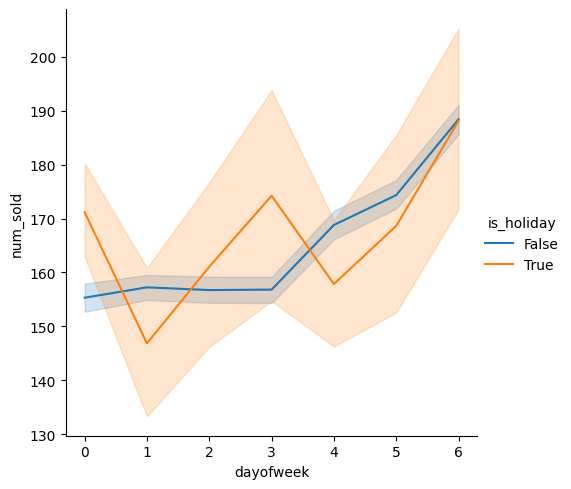

In [38]:
# seaborn relplot for num_sold in each day_of_week vs is_holiday
sns.relplot(x='dayofweek', y='num_sold', hue='is_holiday', data=df_train, kind='line')

c:\Users\Wiktor\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
c:\Users\Wiktor\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


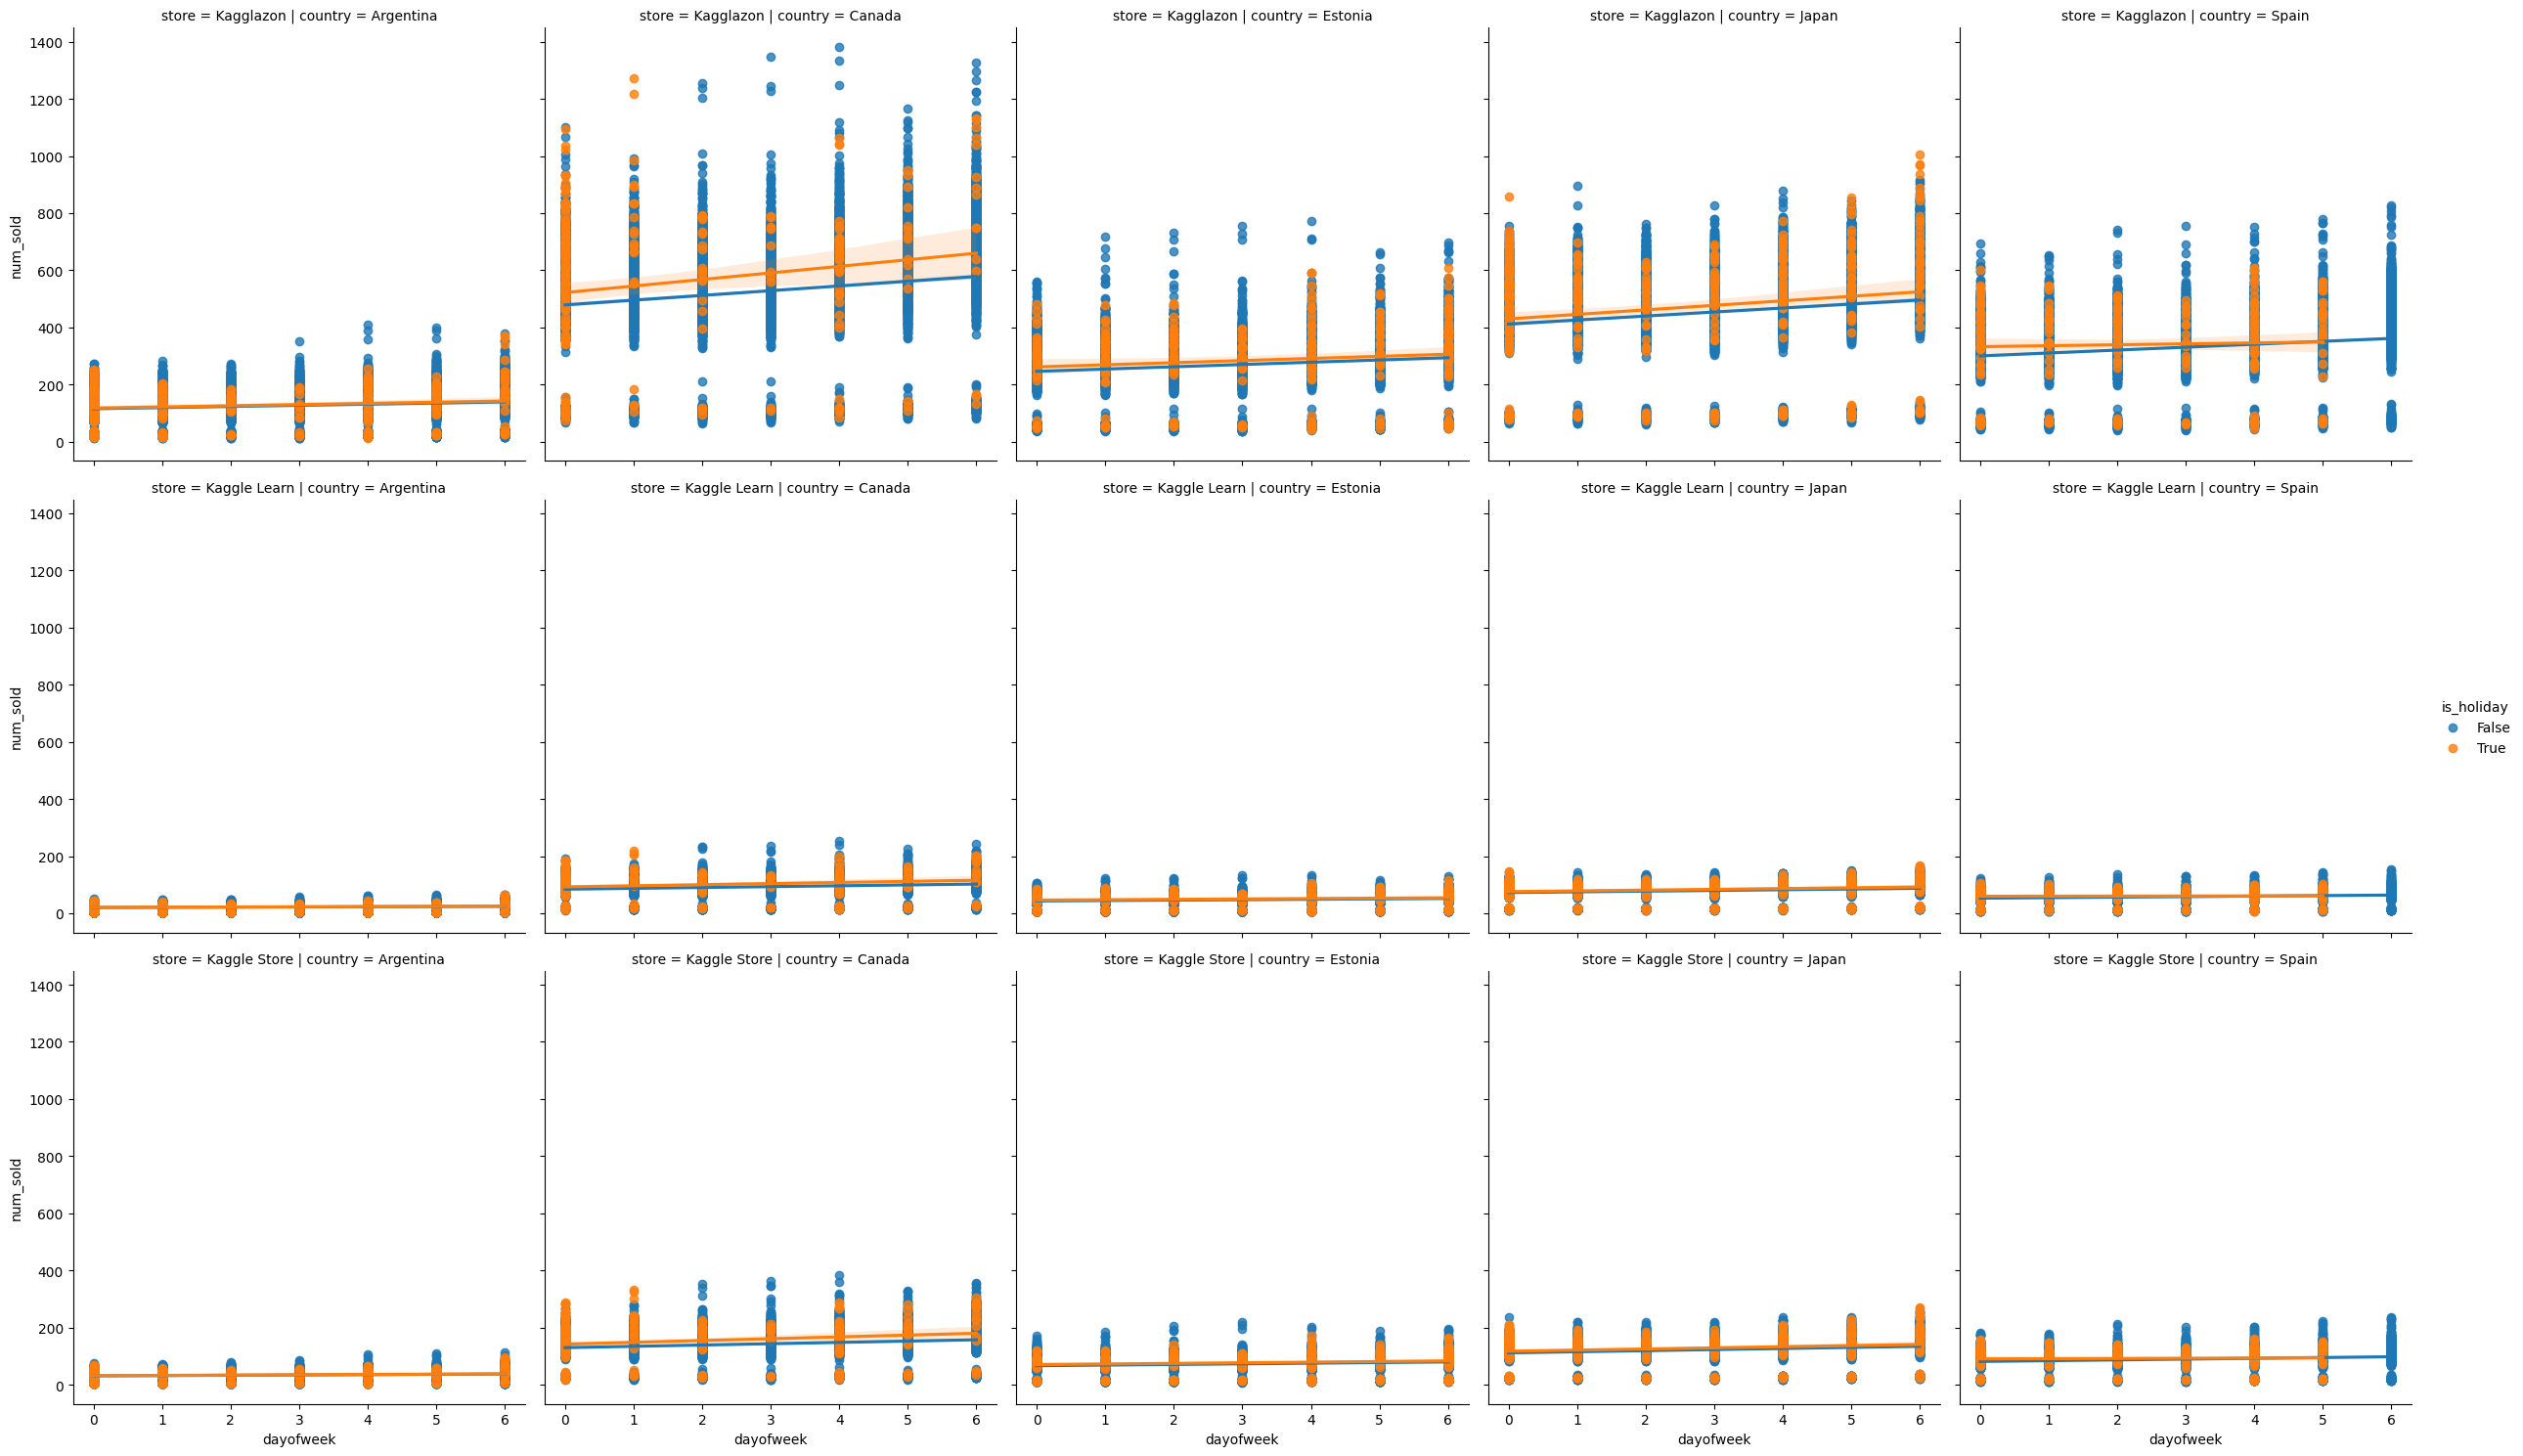

In [41]:
sns.lmplot(
    x="dayofweek", y="num_sold", hue="is_holiday", 
    col="country", row="store", 
    data=df_train)

In [ ]:
import holidays

years_list = [2017, 2018, 2019, 2020, 2021, 2022, 2023]

def add_holidays(df):
    # courtesy of kacperrabczewski in https://www.kaggle.com/code/kacperrabczewski/last-minute-forecasting#Modeling-%F0%9F%AA%84

    Argentina_holidays = holidays.CountryHoliday('AR', years=years_list)
    Canada_holidays = holidays.CountryHoliday('CA', years=years_list)
    Estonia_holidays = holidays.CountryHoliday('EE', years=years_list)
    Japan_holidays = holidays.CountryHoliday('JP', years=years_list)
    Spain_holidays = holidays.CountryHoliday('ES', years=years_list)
    
    # Create Holiday Column 
    df['Argentina_holiday'] = df.loc[df['country'] == 'Argentina', 'date'].apply(lambda d: Argentina_holidays[d] if d in Argentina_holidays else "")
    df['Canada_holiday'] = df.loc[df['country'] == 'Canada', 'date'].apply(lambda d: Canada_holidays[d] if d in Canada_holidays else "")
    df['Estonia_holiday'] = df.loc[df['country'] == 'Estonia', 'date'].apply(lambda d: Estonia_holidays[d] if d in Estonia_holidays else "")
    df['Japan_holiday'] = df.loc[df['country'] == 'Japan', 'date'].apply(lambda d: Japan_holidays[d] if d in Japan_holidays else "")
    df['Spain_holiday'] = df.loc[df['country'] == 'Spain', 'date'].apply(lambda d: Spain_holidays[d] if d in Spain_holidays else "")

    df['Argentina_holiday'] = df['Argentina_holiday'].fillna("")
    df['Canada_holiday'] = df['Canada_holiday'].fillna("")
    df['Estonia_holiday'] = df['Estonia_holiday'].fillna("")
    df['Japan_holiday'] = df['Japan_holiday'].fillna("")
    df['Spain_holiday'] = df['Spain_holiday'].fillna("")
    
    df['holiday_name'] = df['Argentina_holiday'].astype('str') + df['Canada_holiday'].astype('str') \
                    + df['Estonia_holiday'].astype('str') + df['Japan_holiday'].astype('str') \
                    + df['Spain_holiday'].astype('str')
    return df

df_train_holidays = add_holidays(df_train)
df_train_holidays.head()

### Holidays in Argentina

In [ ]:
country = "Argentina"
argentina_df = df_train[df_train['country'] == country]

# plot num_sold vs date
fig, ax = plt.subplots(figsize=(15, 5))

ax.plot(argentina_df['date'], argentina_df['num_sold'], color='cornflowerblue', label='num_sold')
ax.set_xlabel('date')
ax.set_ylabel('num_sold')

ax2 = ax.twinx()
ax2.plot(argentina_df['date'], argentina_df[f'{country}_holiday'], alpha=0.6, color='gold', label=f'is_holiday_in_{country}')
ax2.set_ylabel(f'{country}_holiday')

fig.legend(loc="upper left", bbox_to_anchor=(0,1), bbox_transform=ax.transAxes)
plt.show()

In [ ]:
by_year = argentina_df.groupby(['holiday_name', 'year']).num_sold.mean()

top_holidays = argentina_df.groupby(['holiday_name']).num_sold.mean().sort_values(ascending=False)
top_holidays.head(10)

### Holidays in Canada

In [ ]:
country = "Canada"
canada_df = df_train[df_train['country'] == country]

# plot num_sold vs date
fig, ax = plt.subplots(figsize=(15, 5))

ax.plot(canada_df['date'], canada_df['num_sold'], color='cornflowerblue', label='num_sold')
ax.set_xlabel('date')
ax.set_ylabel('num_sold')

ax2 = ax.twinx()
ax2.plot(canada_df['date'], canada_df[f'{country}_holiday'], alpha=0.6, color='gold', label=f'is_holiday_in_{country}')
ax2.set_ylabel(f'{country}_holiday')

fig.legend(loc="upper left", bbox_to_anchor=(0,1), bbox_transform=ax.transAxes)
plt.show()

In [ ]:
by_year = canada_df.groupby(['holiday_name', 'year']).num_sold.mean()

top_holidays = canada_df.groupby(['holiday_name']).num_sold.mean().sort_values(ascending=False)
top_holidays.head(10)

In [ ]:
order_descending = top_holidays.sort_values(ascending=False).index
# show on horizontal bar chart, first is the biggest num_sold
fig, ax = plt.subplots(figsize=(10, 5))
top_holidays.reset_index().plot.barh(x='holiday_name', y='num_sold', ax=ax)

### Holidays in Japan

In [ ]:
country = "Japan"
japan_df = df_train[df_train['country'] == country]

# plot num_sold vs date
fig, ax = plt.subplots(figsize=(15, 5))

ax.plot(japan_df['date'], japan_df['num_sold'], color='cornflowerblue', label='num_sold')
ax.set_xlabel('date')
ax.set_ylabel('num_sold')

ax2 = ax.twinx()
ax2.plot(japan_df['date'], japan_df[f'{country}_holiday'], alpha=0.6, color='gold', label=f'is_holiday_in_{country}')
ax2.set_ylabel(f'{country}_holiday')

fig.legend(loc="upper left", bbox_to_anchor=(0,1), bbox_transform=ax.transAxes)
plt.show()

In [ ]:
by_year = japan_df.groupby(['holiday_name', 'year']).num_sold.mean()

top_holidays = japan_df.groupby(['holiday_name']).num_sold.mean().sort_values(ascending=False)
top_holidays.head(10)